# SARIMA Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/darcor/PycharmProjects/Setup/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/darcor/PycharmProjects/Setup/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/darcor/PycharmProjects/Setup/.venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/Users/darcor/PycharmProjects/Setup/.venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/darcor/PycharmProjects/Setup/.venv/lib

                                     SARIMAX Results                                      
Dep. Variable:                    Total Con (kWh)   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Tue, 18 Mar 2025   AIC                             10.000
Time:                                    18:00:52   BIC                               -inf
Sample:                                01-31-2023   HQIC                               nan
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5554        nan        nan        nan         nan         nan
ma.L1         -1.3718        nan   

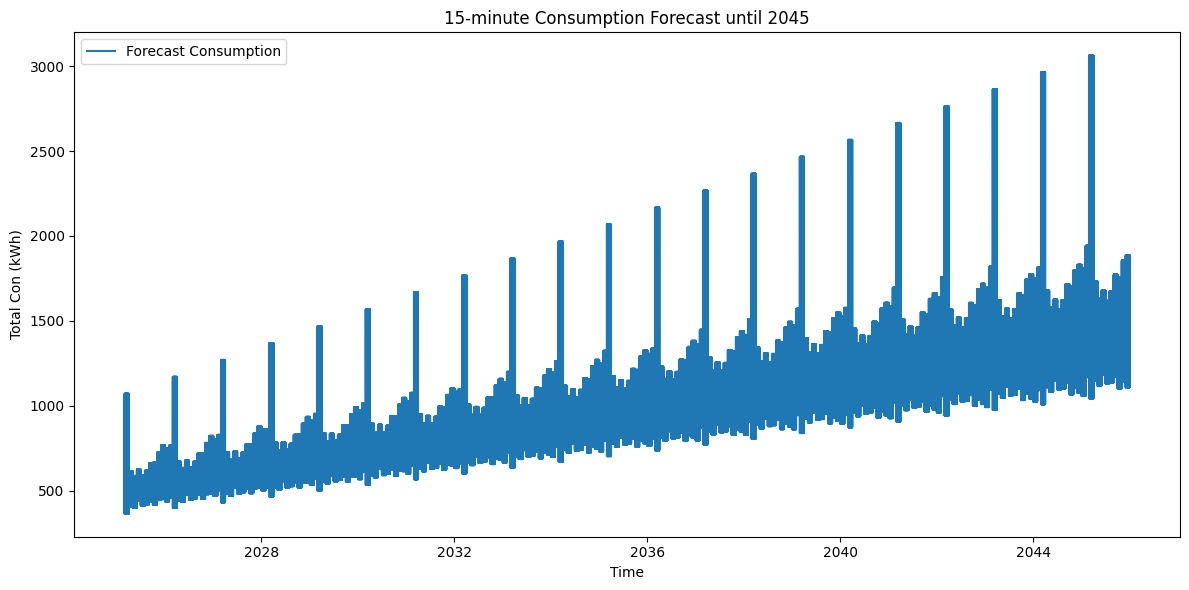

Forecast exported to forecast_15min.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

df = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/e-redes-data/redes_data.xlsx")

# =======================
# 1. Preprocessing & Monthly Aggregation
# =======================

# Convert Date/Time and set index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Ensure the target variable is numeric and fill missing values.
# Use ffill() without inplace to avoid chained assignment warnings.
df['Total Con (kWh)'] = df['Total Con (kWh)'].astype(float)
df_cleaned = df[~df.index.duplicated(keep='first')].copy()
df_cleaned['Total Con (kWh)'] = df_cleaned['Total Con (kWh)'].ffill()

# Aggregate to monthly data.
# Use 'ME' (month-end) instead of 'M' to avoid deprecation warnings.
df_monthly = df_cleaned['Total Con (kWh)'].resample('ME').mean()

# =======================
# 2. Fit SARIMA on the Monthly Data
# =======================

# For monthly data a common seasonal period is 12 (months).
model_monthly = SARIMAX(df_monthly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, enforce_invertibility=False)
result_monthly = model_monthly.fit(disp=False)
print(result_monthly.summary())

# -----------------------
# Forecast monthly until 2045
# -----------------------
last_month = df_monthly.index[-1]
end_date = pd.to_datetime('2045-12-31')
forecast_index_monthly = pd.date_range(start=last_month, end=end_date, freq='ME')
n_steps = len(forecast_index_monthly)

forecast_monthly = result_monthly.get_forecast(steps=n_steps)
forecast_monthly_series = forecast_monthly.predicted_mean
forecast_monthly_series.index = forecast_index_monthly

# =======================
# 3. Build a Typical Daily 15-Minute Profile from Historical Data
# =======================

# Resample the cleaned data to 15-minute intervals (using forward-fill).
df_15min = df_cleaned['Total Con (kWh)'].resample('15min').ffill()

# Build a DataFrame with daily data.
df_daily = df_15min.to_frame(name='consumption')
df_daily['date'] = df_daily.index.date

# Compute each day’s total consumption.
daily_totals = df_daily.groupby('date')['consumption'].transform('sum')
df_daily['fraction'] = df_daily['consumption'] / daily_totals

# Extract the time-of-day (as a time object) and month (using the .dt accessor).
df_daily['time'] = df_daily.index.time
df_daily['month'] = pd.to_datetime(df_daily['date']).dt.month

# Compute the average daily profile for each month: fraction per 15-min slot.
daily_profile = df_daily.groupby(['month', 'time'])['fraction'].mean().reset_index()

# Re-normalize the profile for each month so the fractions sum to 1.
def renormalize_profile(month_df):
    total = month_df['fraction'].sum()
    month_df['fraction'] = month_df['fraction'] / total
    return month_df

daily_profile = daily_profile.groupby('month').apply(renormalize_profile).reset_index(drop=True)

# =======================
# 4. Disaggregate Monthly Forecasts to 15-Minute Resolution
# =======================

def disaggregate_monthly_to_15min(monthly_forecast, daily_profile):
    """
    Disaggregates a monthly forecast Series (index is a Timestamp for each month)
    into a 15-minute resolution forecast using typical daily profiles.
    """
    forecast_15min_list = []

    for month_end, monthly_value in monthly_forecast.items():
        month_num = month_end.month
        # Define start of the month as the first day and end as the month-end date.
        month_start = month_end.replace(day=1)
        # Generate daily dates for the month.
        all_days = pd.date_range(start=month_start, end=month_end, freq='D')
        num_days = len(all_days)
        
        # Distribute the monthly forecast equally among all days.
        daily_total = monthly_value / num_days
        
        # Extract the typical daily profile for this month.
        profile_month = daily_profile[daily_profile['month'] == month_num].copy()
        # Create a 15-minute time index for one day (00:00 to 23:45).
        day_times = pd.date_range(start='00:00', end='23:45', freq='15min').time
        profile_month = profile_month.set_index('time').reindex(day_times)
        # Interpolate missing values and re-normalize.
        profile_month['fraction'] = profile_month['fraction'].interpolate(method='linear')
        profile_month['fraction'] = profile_month['fraction'] / profile_month['fraction'].sum()
        
        # Build a 15-min series for each day using the profile fractions.
        month_15min = []
        for day in all_days:
            times = pd.date_range(start=pd.to_datetime(day), periods=96, freq='15min')
            day_values = daily_total * profile_month['fraction'].values
            s = pd.Series(day_values, index=times)
            month_15min.append(s)
        
        month_series = pd.concat(month_15min)
        forecast_15min_list.append(month_series)
    
    forecast_15min = pd.concat(forecast_15min_list)
    return forecast_15min

forecast_15min = disaggregate_monthly_to_15min(forecast_monthly_series, daily_profile)

# =======================
# 5. Plot the Forecast and Export to Excel
# =======================

# Plotting the 15-minute forecast.
plt.figure(figsize=(12, 6))
plt.plot(forecast_15min.index, forecast_15min.values, label='Forecast Consumption')
plt.title('15-minute Consumption Forecast until 2045')
plt.xlabel('Time')
plt.ylabel('Total Con (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

# Prepare the DataFrame for export.
forecast_df = forecast_15min.to_frame(name='Total Con (kWh)')

# Export the forecast to an Excel file.
export_path = "forecast_15min.xlsx"
forecast_df.to_excel(export_path)
print(f"Forecast exported to {export_path}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------
# 1. Load Data and Preprocess
# -----------------------
df = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/e-redes-data/redes_data.xlsx")

# Convert Date/Time and set index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Ensure the target variable is numeric and fill missing values.
df['Total Con (kWh)'] = df['Total Con (kWh)'].astype(float)
df_cleaned = df[~df.index.duplicated(keep='first')].copy()
df_cleaned['Total Con (kWh)'] = df_cleaned['Total Con (kWh)'].ffill()

# Aggregate to monthly data using month-end frequency.
df_monthly = df_cleaned['Total Con (kWh)'].resample('ME').mean()

# -----------------------
# 2. Build a Deterministic Monthly Forecast Using Your Growth Assumptions
# -----------------------

# For this example, assume the baseline is the last observed month.
baseline_date = df_monthly.index[-1]
baseline_value = df_monthly.iloc[-1]

# Define simulation start and end dates.
sim_start = baseline_date + pd.offsets.MonthEnd(1)
sim_end = pd.to_datetime('2045-12-31')

# Create a monthly date range for the simulation period.
forecast_index_monthly = pd.date_range(start=sim_start, end=sim_end, freq='ME')

# Build a dictionary of annual growth rates.
# For years 2026-2030 use the specified rates, then 1% for 2031 onward.
growth_rates = {}
for year in range(sim_start.year, sim_end.year+1):
    if year == 2026:
        growth_rates[year] = 0.02
    elif year == 2027:
        growth_rates[year] = 0.015
    elif year == 2028:
        growth_rates[year] = 0.03
    elif year == 2029:
        growth_rates[year] = 0.02
    elif year == 2030:
        growth_rates[year] = 0.05
    else:
        growth_rates[year] = 0.01

# Create a deterministic monthly forecast series.
# We assume that within each year, the monthly growth factor is:
#    monthly_factor = (1 + annual_growth)^(1/12)
deterministic_forecast = []
current_value = baseline_value
current_date = baseline_date

for date in forecast_index_monthly:
    # Check if we are in a new year.
    if date.year != current_date.year:
        current_date = date
    annual_growth = growth_rates[date.year]
    monthly_factor = (1 + annual_growth) ** (1/12)
    current_value = current_value * monthly_factor
    deterministic_forecast.append(current_value)

deterministic_forecast_series = pd.Series(deterministic_forecast, index=forecast_index_monthly)

# -----------------------
# 3. Build the Typical Daily 15-Minute Profile from Historical Data
# -----------------------

# Resample the cleaned data to 15-minute intervals.
df_15min = df_cleaned['Total Con (kWh)'].resample('15min').ffill()

# Build a DataFrame with daily data.
df_daily = df_15min.to_frame(name='consumption')
df_daily['date'] = df_daily.index.date

# Compute each day’s total consumption.
daily_totals = df_daily.groupby('date')['consumption'].transform('sum')
df_daily['fraction'] = df_daily['consumption'] / daily_totals

# Extract time-of-day and month.
df_daily['time'] = df_daily.index.time
df_daily['month'] = pd.to_datetime(df_daily['date']).dt.month

# Compute the average daily profile for each month: fraction per 15-min slot.
daily_profile = df_daily.groupby(['month', 'time'])['fraction'].mean().reset_index()

# Re-normalize the profile for each month so fractions sum to 1.
def renormalize_profile(month_df):
    total = month_df['fraction'].sum()
    month_df['fraction'] = month_df['fraction'] / total
    return month_df

daily_profile = daily_profile.groupby('month', group_keys=False).apply(renormalize_profile).reset_index(drop=True)

# -----------------------
# 4. Disaggregate Monthly Forecasts to 15-Minute Resolution with Monte Carlo Variation
# -----------------------

def disaggregate_monthly_to_15min_MC(monthly_forecast, daily_profile, noise_daily=0.05):
    """
    Disaggregates a monthly forecast Series into a 15-minute resolution forecast.
    For each day, applies a random variation drawn from Uniform(-noise_daily, noise_daily).
    """
    forecast_15min_list = []

    for month_end, monthly_value in monthly_forecast.items():
        month_num = month_end.month
        # Month start is first day; month end from the forecast index.
        month_start = month_end.replace(day=1)
        all_days = pd.date_range(start=month_start, end=month_end, freq='D')
        num_days = len(all_days)
        
        # Distribute monthly total equally among days.
        daily_total = monthly_value / num_days
        
        # Extract typical daily profile for this month.
        profile_month = daily_profile[daily_profile['month'] == month_num].copy()
        # Create a 15-minute time index for one day (00:00 to 23:45).
        day_times = pd.date_range(start='00:00', end='23:45', freq='15min').time
        profile_month = profile_month.set_index('time').reindex(day_times)
        profile_month['fraction'] = profile_month['fraction'].interpolate(method='linear')
        profile_month['fraction'] = profile_month['fraction'] / profile_month['fraction'].sum()
        
        # For each day, add a random multiplier from Uniform(1-noise_daily, 1+noise_daily)
        month_15min = []
        for day in all_days:
            random_factor = 1 + np.random.uniform(-noise_daily, noise_daily)
            times = pd.date_range(start=pd.to_datetime(day), periods=96, freq='15min')
            day_values = daily_total * random_factor * profile_month['fraction'].values
            s = pd.Series(day_values, index=times)
            month_15min.append(s)
        
        month_series = pd.concat(month_15min)
        forecast_15min_list.append(month_series)
    
    forecast_15min = pd.concat(forecast_15min_list)
    return forecast_15min

# Number of Monte Carlo simulations
num_simulations = 1000
all_simulations = []

for sim in range(num_simulations):
    # For each simulation, optionally add additional random variation at the monthly level.
    # Here we multiply each deterministic monthly forecast by a random factor (±0-5%).
    monthly_variation = deterministic_forecast_series * (1 + np.random.uniform(-0.05, 0.05, size=len(deterministic_forecast_series)))
    # Disaggregate this monthly forecast to 15-min resolution with daily noise.
    sim_forecast = disaggregate_monthly_to_15min_MC(monthly_variation, daily_profile, noise_daily=0.05)
    all_simulations.append(sim_forecast)

# Combine simulations into a DataFrame (align on the index)
simulations_df = pd.concat(all_simulations, axis=1)
simulations_df.columns = [f"sim_{i}" for i in range(num_simulations)]

# Calculate statistics at each 15-min timestamp (e.g., median, 10th, 90th percentile)
median_forecast = simulations_df.median(axis=1)
p10_forecast = simulations_df.quantile(0.10, axis=1)
p90_forecast = simulations_df.quantile(0.90, axis=1)

# -----------------------
# 5. Plot and Export Results
# -----------------------

plt.figure(figsize=(14, 7))
plt.plot(median_forecast.index, median_forecast.values, label='Median Forecast', color='blue')
plt.fill_between(median_forecast.index, p10_forecast, p90_forecast, color='blue', alpha=0.2, label='P10-P90 range')
plt.title('15-minute Consumption Forecast until 2045 (Monte Carlo Simulation)')
plt.xlabel('Time')
plt.ylabel('Total Con (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

# Export one of the simulation results (or the median) to Excel.
export_df = median_forecast.to_frame(name='Total Con (kWh)')
export_path = "forecast_15min_median.xlsx"
export_df.to_excel(export_path)
print(f"Median forecast exported to {export_path}")

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_22712/3217778434.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_profile = daily_profile.groupby('month', group_keys=False).apply(renormalize_profile).reset_index(drop=True)


/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_23381/3046189636.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(renormalize_profile)


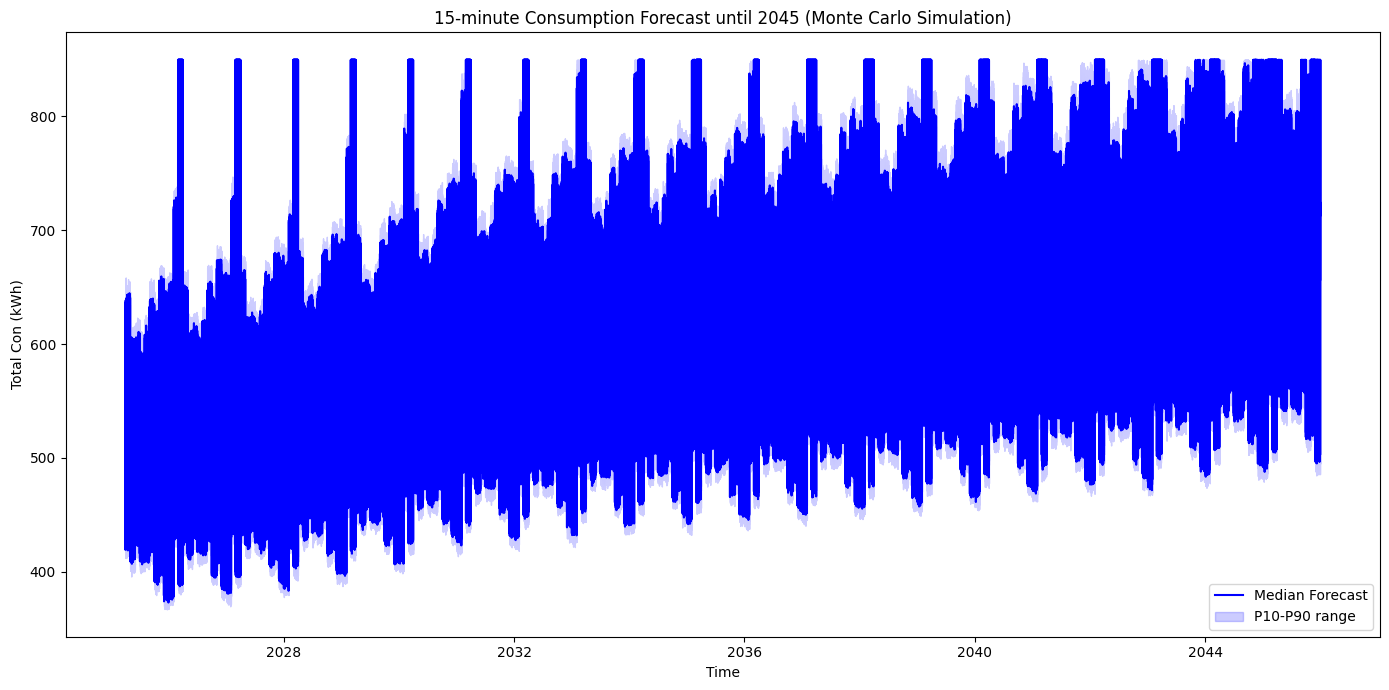

Median forecast exported to: forecast_15min_median_clamped.xlsx


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --------------------------------------------------
# 1. Load Data and Preprocess
# --------------------------------------------------
df = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/e-redes-data/redes_data.xlsx")

# Convert Date/Time and set as index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Ensure target variable is numeric and fill missing
df['Total Con (kWh)'] = df['Total Con (kWh)'].astype(float)
df_cleaned = df[~df.index.duplicated(keep='first')].copy()
df_cleaned['Total Con (kWh)'] = df_cleaned['Total Con (kWh)'].ffill()

# Aggregate to monthly data using month-end frequency
df_monthly = df_cleaned['Total Con (kWh)'].resample('ME').mean()

# --------------------------------------------------
# 2. Build a Deterministic Monthly Forecast
#    Using Your Growth Assumptions
# --------------------------------------------------

# Baseline: last observed month
baseline_date = df_monthly.index[-1]
baseline_value = df_monthly.iloc[-1]

# Simulation range
sim_start = baseline_date + pd.offsets.MonthEnd(1)
sim_end = pd.to_datetime('2045-12-31')

# Monthly date range for forecast
forecast_index_monthly = pd.date_range(start=sim_start, end=sim_end, freq='ME')

# Dictionary of annual growth rates (example)
growth_rates = {}
for year in range(sim_start.year, sim_end.year + 1):
    if year == 2026:
        growth_rates[year] = 0.02
    elif year == 2027:
        growth_rates[year] = 0.015
    elif year == 2028:
        growth_rates[year] = 0.03
    elif year == 2029:
        growth_rates[year] = 0.02
    elif year == 2030:
        growth_rates[year] = 0.05
    else:
        growth_rates[year] = 0.01

# Build deterministic monthly forecast
deterministic_forecast_values = []
current_value = baseline_value
current_date = baseline_date

for date in forecast_index_monthly:
    if date.year != current_date.year:
        current_date = date
    annual_growth = growth_rates[date.year]
    monthly_factor = (1 + annual_growth) ** (1/12)
    current_value *= monthly_factor
    deterministic_forecast_values.append(current_value)

deterministic_forecast_series = pd.Series(deterministic_forecast_values,
                                          index=forecast_index_monthly)

# --------------------------------------------------
# 3. Build the Typical Daily 15-Minute Profile
# --------------------------------------------------

# Resample to 15-min intervals
df_15min = df_cleaned['Total Con (kWh)'].resample('15min').ffill()

# Create a DataFrame for daily fraction calculation
df_daily = df_15min.to_frame(name='consumption')
df_daily['date'] = df_daily.index.date

# Compute each day’s total consumption
daily_totals = df_daily.groupby('date')['consumption'].transform('sum')
df_daily['fraction'] = df_daily['consumption'] / daily_totals

# Extract time-of-day and month
df_daily['time'] = df_daily.index.time
df_daily['month'] = pd.to_datetime(df_daily['date']).dt.month

# Average daily profile for each (month, time)
daily_profile = df_daily.groupby(['month', 'time'])['fraction'].mean().reset_index()

# Re-normalize each month’s fractions to sum to 1
def renormalize_profile(month_df):
    total = month_df['fraction'].sum()
    month_df['fraction'] = month_df['fraction'] / total
    return month_df

daily_profile = (daily_profile
                 .groupby('month', group_keys=False)
                 .apply(renormalize_profile)
                 .reset_index(drop=True))

# --------------------------------------------------
# 4. Disaggregate Monthly Forecasts to 15-Minute
#    with Monte Carlo Variation & Clamping
# --------------------------------------------------

def disaggregate_monthly_to_15min_MC(monthly_forecast, daily_profile,
                                     noise_daily=0.02, daily_factor_clip=0.03):
    """
    Disaggregates a monthly forecast Series into a 15-minute resolution forecast.
    Adds random daily variation in [1-noise_daily, 1+noise_daily], then clamps it
    to avoid extreme outliers.
    """
    forecast_15min_list = []

    for month_end, monthly_value in monthly_forecast.items():
        month_num = month_end.month
        month_start = month_end.replace(day=1)
        all_days = pd.date_range(start=month_start, end=month_end, freq='D')
        num_days = len(all_days)
        
        # Distribute monthly total equally among days
        daily_total = monthly_value / num_days

        # Extract typical daily profile for this month
        profile_month = daily_profile[daily_profile['month'] == month_num].copy()
        # 15-min time index for a single day
        day_times = pd.date_range(start='00:00', end='23:45', freq='15min').time
        profile_month = profile_month.set_index('time').reindex(day_times)
        profile_month['fraction'] = profile_month['fraction'].interpolate(method='linear')
        profile_month['fraction'] = profile_month['fraction'] / profile_month['fraction'].sum()
        
        # Construct each day
        for day in all_days:
            raw_factor = np.random.uniform(-noise_daily, noise_daily)
            # Clamp that factor to avoid extremes
            raw_factor = np.clip(raw_factor, -daily_factor_clip, daily_factor_clip)
            random_factor = 1 + raw_factor
            
            times = pd.date_range(start=pd.to_datetime(day), periods=96, freq='15min')
            day_values = daily_total * random_factor * profile_month['fraction'].values
            s = pd.Series(day_values, index=times)
            forecast_15min_list.append(s)
    
    forecast_15min = pd.concat(forecast_15min_list)
    return forecast_15min

# Number of Monte Carlo simulations
num_simulations = 10
all_simulations = []

for sim in range(num_simulations):
    # Add smaller random variation at monthly level: ±2%
    monthly_variation = deterministic_forecast_series * (
        1 + np.random.uniform(-0.02, 0.02, size=len(deterministic_forecast_series))
    )
    # Disaggregate with daily factor clamp
    sim_forecast = disaggregate_monthly_to_15min_MC(monthly_variation,
                                                    daily_profile,
                                                    noise_daily=0.02,
                                                    daily_factor_clip=0.03)
    all_simulations.append(sim_forecast)

# Combine simulations
simulations_df = pd.concat(all_simulations, axis=1)
simulations_df.columns = [f"sim_{i}" for i in range(num_simulations)]

# --------------------------------------------------
# 5. Final Outlier Clamp Across All Simulations
# --------------------------------------------------
upper_clip = simulations_df.stack().quantile(0.995)
simulations_df = simulations_df.clip(upper=upper_clip)

# Compute summary stats
median_forecast = simulations_df.median(axis=1)
p10_forecast = simulations_df.quantile(0.10, axis=1)
p90_forecast = simulations_df.quantile(0.90, axis=1)

# --------------------------------------------------
# 6. Plot and Export Results
# --------------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(median_forecast.index, median_forecast.values,
         label='Median Forecast', color='blue')
plt.fill_between(median_forecast.index, p10_forecast, p90_forecast,
                 color='blue', alpha=0.2, label='P10-P90 range')
plt.title('15-minute Consumption Forecast until 2045 (Monte Carlo Simulation)')
plt.xlabel('Time')
plt.ylabel('Total Con (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

# Optionally export median forecast to Excel
export_df = median_forecast.to_frame(name='Total Con (kWh)')
export_path = "forecast_15min_median_clamped.xlsx"
export_df.to_excel(export_path, index=True)
print(f"Median forecast exported to: {export_path}")